In [1]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224

In [2]:
import tensorflow as tf

In [3]:
import tensorflow_datasets as tfds

batch_size = 64

dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes


When the dataset include images with various size, we need to resize them into a
shared size. The Stanford Dogs dataset includes only images at least 200x200
pixels in size. Here we resize the images to the input size needed for EfficientNet.

In [4]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

### Visualizing the data

The following code shows the first 9 images with their labels.

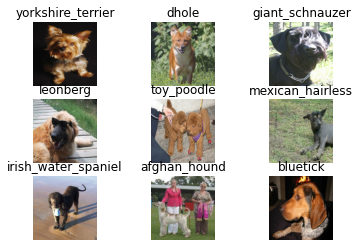

In [5]:
import matplotlib.pyplot as plt


def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")


### Data augmentation

We can use preprocessing layers APIs for image augmentation.

In [6]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

This `Sequential` model object can be used both as a part of
the model we later build, and as a function to preprocess
data before feeding into the model. Using them as function makes
it easy to visualize the augmented images. Here we plot 9 examples
of augmentation result of a given figure.

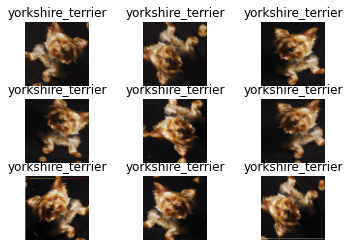

In [7]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")


### Prepare inputs

Once we verify the input data and augmentation are working correctly,
we prepare dataset for training. The input data are resized to uniform
`IMG_SIZE`. The labels are put into one-hot
(a.k.a. categorical) encoding. The dataset is batched.

Note: `prefetch` and `AUTOTUNE` may in some situation improve
performance, but depends on environment and the specific dataset used.
See this [guide](https://www.tensorflow.org/guide/data_performance)
for more information on data pipeline performance.

In [8]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)


Training the model is relatively fast (takes only 20 seconds per epoch on TPUv2 that is
available on Colab). This might make it sounds easy to simply train EfficientNet on any
dataset wanted from scratch. However, training EfficientNet on smaller datasets,
especially those with lower resolution like CIFAR-100, faces the significant challenge of
overfitting.

Hence training from scratch requires very careful choice of hyperparameters and is
difficult to find suitable regularization. It would also be much more demanding in resources.
Plotting the training and validation accuracy
makes it clear that validation accuracy stagnates at a low value.

In [9]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


## Transfer learning from pre-trained weights

Here we initialize the model with pre-trained ImageNet weights,
and we fine-tune it on our own dataset.

In [10]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2


def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = MobileNetV2(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


The first step to transfer learning is to freeze all layers and train only the top
layers. For this step, a relatively large learning rate (1e-2) can be used.
Note that validation accuracy and loss will usually be better than training
accuracy and loss. This is because the regularization is strong, which only
suppresses training-time metrics.

Note that the convergence may take up to 50 epochs depending on choice of learning rate.
If image augmentation layers were not
applied, the validation accuracy may only reach ~60%.

In [13]:
epochs = 30
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "../tf_models/local/best_local1.h5",
        monitor="val_loss",
        save_best_only=True,
        verbose=1),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1),
]
model = build_model(num_classes=NUM_CLASSES)

hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, callbacks=callbacks)
plot_hist(hist)

Epoch 1/30
187/187 [==============================] - ETA: 0s - loss: 3.5389 - accuracy: 0.3711
Epoch 00001: val_loss improved from inf to 0.96932, saving model to ../tf_models/local/best_local1.h5
187/187 [==============================] - 752s 4s/step - loss: 3.5389 - accuracy: 0.3711 - val_loss: 0.9693 - val_accuracy: 0.7048
Epoch 2/30
187/187 [==============================] - ETA: 0s - loss: 1.8634 - accuracy: 0.5222
Epoch 00002: val_loss improved from 0.96932 to 0.80025, saving model to ../tf_models/local/best_local1.h5
187/187 [==============================] - 752s 4s/step - loss: 1.8634 - accuracy: 0.5222 - val_loss: 0.8003 - val_accuracy: 0.7523
Epoch 3/30
187/187 [==============================] - ETA: 0s - loss: 1.5534 - accuracy: 0.5762
Epoch 00003: val_loss improved from 0.80025 to 0.76858, saving model to ../tf_models/local/best_local1.h5
187/187 [==============================] - 765s 4s/step - loss: 1.5534 - accuracy: 0.5762 - val_loss: 0.7686 - val_accuracy: 0.7629
Ep

KeyboardInterrupt: 

The second step is to unfreeze a number of layers and fit the model using smaller
learning rate. In this example we show unfreezing all layers, but depending on
specific dataset it may be desireble to only unfreeze a fraction of all layers.

When the feature extraction with
pretrained model works good enough, this step would give a very limited gain on
validation accuracy. In our case we only see a small improvement,
as ImageNet pretraining already exposed the model to a good amount of dogs.

On the other hand, when we use pretrained weights on a dataset that is more different
from ImageNet, this fine-tuning step can be crucial as the feature extractor also
needs to be adjusted by a considerable amount. Such a situation can be demonstrated
if choosing CIFAR-100 dataset instead, where fine-tuning boosts validation accuracy
by about 10% to pass 80% on `EfficientNetB0`.
In such a case the convergence may take more than 50 epochs.

A side note on freezing/unfreezing models: setting `trainable` of a `Model` will
simultaneously set all layers belonging to the `Model` to the same `trainable`
attribute. Each layer is trainable only if both the layer itself and the model
containing it are trainable. Hence when we need to partially freeze/unfreeze
a model, we need to make sure the `trainable` attribute of the model is set
to `True`.

In [ ]:
# load saved model


In [ ]:

def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 10  # @param {type: "slider", min:8, max:50}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
plot_hist(hist)

In [ ]:
# save the model 
export_dir = 'saved/1'
tf.saved_model.save(model, export_dir)

In [ ]:
# convert to tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()


In [ ]:
import pathlib

tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

In [ ]:
# test

# load model 
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
#
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details, output_details)

In [ ]:
# Test the TensorFlow Lite model on random input data.
import numpy as np
input_shape = input_details[0]['shape']
inputsl, outputsl = [], []
for _ in range(100):
    input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    
    interpreter.invoke()
    tflite_results = interpreter.get_tensor(output_details[0]['index'])
    
    # Test the TensorFlow model on random input data.
    tf_results = model(tf.constant(input_data))
    output_data = np.array(tf_results)
    
    inputsl.append(input_data[0][0])
    outputsl.append(output_data[0][0])

In [ ]:
%matplotlib inline
plt.plot(inputsl, outputsl, 'r')
plt.show()

In [ ]:
try:
    from google.colab import files
    files.download(export_dir)
except:
    pass

In [ ]:
!pwd
!ls
!zip -r /content/model.zip /content/saved/1

In [ ]:
from google.colab import files
  files.download('/content/model.zip')

### Tips for fine tuning EfficientNet

On unfreezing layers:

- The `BathcNormalization` layers need to be kept frozen
([more details](https://keras.io/guides/transfer_learning/)).
If they are also turned to trainable, the
first epoch after unfreezing will significantly reduce accuracy.
- In some cases it may be beneficial to open up only a portion of layers instead of
unfreezing all. This will make fine tuning much faster when going to larger models like
B7.
- Each block needs to be all turned on or off. This is because the architecture includes
a shortcut from the first layer to the last layer for each block. Not respecting blocks
also significantly harms the final performance.

Some other tips for utilizing EfficientNet:

- Larger variants of EfficientNet do not guarantee improved performance, especially for
tasks with less data or fewer classes. In such a case, the larger variant of EfficientNet
chosen, the harder it is to tune hyperparameters.
- EMA (Exponential Moving Average) is very helpful in training EfficientNet from scratch,
but not so much for transfer learning.
- Do not use the RMSprop setup as in the original paper for transfer learning. The
momentum and learning rate are too high for transfer learning. It will easily corrupt the
pretrained weight and blow up the loss. A quick check is to see if loss (as categorical
cross entropy) is getting significantly larger than log(NUM_CLASSES) after the same
epoch. If so, the initial learning rate/momentum is too high.
- Smaller batch size benefit validation accuracy, possibly due to effectively providing
regularization.

## Using the latest EfficientNet weights

Since the initial paper, the EfficientNet has been improved by various methods for data
preprocessing and for using unlabelled data to enhance learning results. These
improvements are relatively hard and computationally costly to reproduce, and require
extra code; but the weights are readily available in the form of TF checkpoint files. The
model architecture has not changed, so loading the improved checkpoints is possible.

To use a checkpoint provided at
[the official model repository](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet), first
download the checkpoint. As example, here we download noisy-student version of B1:

```
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet\
       /noisystudent/noisy_student_efficientnet-b1.tar.gz
!tar -xf noisy_student_efficientnet-b1.tar.gz
```

Then use the script [efficientnet_weight_update_util.py](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/keras/applications/efficientnet_weight_update_util.py) to convert ckpt file to h5 file.

```
!python efficientnet_weight_update_util.py --model b1 --notop --ckpt \
        efficientnet-b1/model.ckpt --o efficientnetb1_notop.h5
```

When creating model, use the following to load new weight:

```python
model = EfficientNetB1(weights="efficientnetb1_notop.h5", include_top=False)
```